<a href="https://colab.research.google.com/github/Hlogy/Deep-learning-image-classification-efficientnetb0/blob/main/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install ipython-autotime
%load_ext autotime

In [ ]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image,  ImageTk
from sklearn.model_selection import train_test_split
from pathlib import Path

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/trashnet.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
zip_ref = zipfile.ZipFile('/tmp/trashnet-data/dataset-resized.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp/trashdata') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
#Delete Trash class (downsampling since class has only around 100 images)
%rm -rf /tmp/trashdata/dataset-resized/trash

In [ ]:
im_dir = Path('/tmp/trashdata/dataset-resized')

In [ ]:
filepaths = list(im_dir.glob(r'**/*.jpg'))

In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
  #os.path.split(os.path.split(filepaths[0])[0])[1]
print (labels)

In [ ]:
#Creating a Dataframe for both filepaths and labels:
filepaths = pd.Series(filepaths, name='Filepath').astype(str) #Turned to String
labels = pd.Series(labels, name='Labels')
print(labels)

In [ ]:
images = pd.concat([filepaths, labels], axis=1)
images

In [ ]:
image_df = images.sample(frac=1).reset_index(drop=True)
image_df

In [ ]:
#Split images in image_df to train and test using functoin below from sklearn, with the following properties:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
#Generators are a way of loading in the images one batch at a time so that we do not run out of memory
#ex: set the batch size for 32, load 32 images, train on them, then recycle the memory for the next batch so we don't runout
#here we can specify any image preprocssing we want to apply to images and any data augmentation
#The moblienetv2 will be used now, later mobilenetv3 and others:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    #Specifying preprocessing function. Will come form keras mobilenetv2 processing function
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    validation_split = 0.2,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    #Specifying preprocessing function. Will come form keras mobilenetv2 processing function
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
)

In [ ]:
#Now, using generators to specify how to load data during training

train_img = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)
val_img = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)
test_img = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Labels',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
)

In [ ]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape = (224,224,3),
    include_top = False,
    weights='imagenet',
    #pooling='avg'
)
pretrained_model.trainable = False


In [ ]:
from tensorflow.keras import layers

In [ ]:
inputs = pretrained_model.input


x = tf.keras.layers.Dense(128,activation='relu')(pretrained_model.output)
#x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = tf.keras.layers.BatchNormalization()(x)
top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)

outputs = tf.keras.layers.Dense(5,activation='softmax')(x)

model = tf.keras.Model(inputs,outputs)

for layer in model.layers:
  if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

print(model.summary())

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_img,
    validation_data=val_img,
    epochs = 50,
    verbose=1,
    callbacks=[
             #tf.keras.callbacks.EarlyStopping(
               #    monitor = 'val_loss',
               #    mode = 'min',
               #    patience=10,
               #    verbose=1,
               #   restore_best_weights=True
               #),
               ReduceLROnPlateau(monitor='val_loss', 
                                 mode='min', 
                                 patience= 5, 
                                 factor= 0.5, 
                                 min_lr= 1e-6, 
                                 verbose=1)
    ]
)

In [ ]:
results = model.evaluate(test_img,verbose=1)
print('Test Accuracy: {:.2f}%'.format(results[1]*100))

In [ ]:
predictions = np.argmax(model.predict(test_img),axis=1)
cm = confusion_matrix(test_img.labels,predictions)
clr = classification_report(test_img.labels,predictions, target_names=test_img.class_indices)

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g',vmin=0,cmap='Blues',cbar=True)
plt.xticks(ticks=np.arange(5)+0.5, labels=test_img.class_indices, rotation=90)
plt.yticks(ticks=np.arange(5)+0.5, labels=test_img.class_indices, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Classification Report:\n--------------------------------------------------------\n", clr)

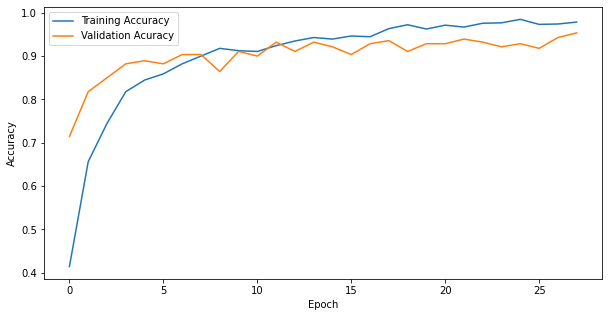

time: 192 ms (started: 2021-11-20 12:31:55 +00:00)


In [ ]:
plt.figure(figsize=[10,5])
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Acuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

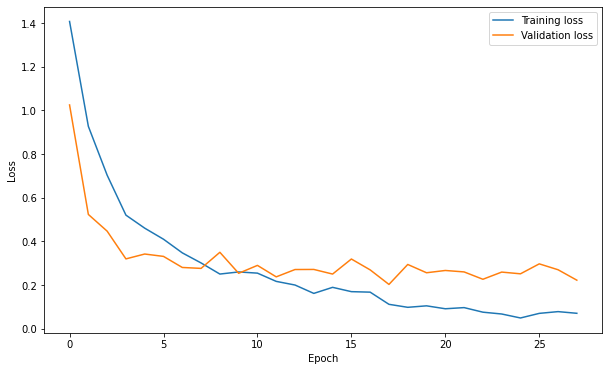

time: 174 ms (started: 2021-11-20 12:31:58 +00:00)


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()